# Оптимизация производства восстановления золота из руды.

**Процесс получения золота из руды**
<br>
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
- **Флотация.** Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости)
- **Очистка.** Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Цель проекта:** Подготовить прототип модели машинного обучения для компании «Цифры». Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.
<br>
**Задачи проекта:** 
- Подготовить данные
- Провести исследовательский анализ данных
- Построить и обучить модель

**Описание данных**

Технологический процесс
<br>
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золотадачи

Параметры этапов
<br>
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from collections import defaultdict

## Шаг 1. Подготовка данных

### Загрузка и изучение данных

In [2]:
try:
    df_train = pd.read_csv('/datasets/gold_industry_train.csv', parse_dates = ['date'])
    df_test = pd.read_csv('/datasets/gold_industry_test.csv', parse_dates = ['date'])
    df_full = pd.read_csv('/datasets/gold_industry_full.csv', parse_dates = ['date'])
except:
    df_train = pd.read_csv('gold_industry_train.csv', parse_dates = ['date'])
    df_test = pd.read_csv('gold_industry_test.csv', parse_dates = ['date'])
    df_full = pd.read_csv('gold_industry_full.csv', parse_dates = ['date'])

In [3]:
df_train.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [4]:
df_test.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [5]:
df_full.head()

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [6]:
print(df_train.info())
print(df_test.info())
print(df_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14579 non-null  datetime64[ns]
 1   rougher.input.feed_au                               14579 non-null  float64       
 2   rougher.input.feed_ag                               14579 non-null  float64       
 3   rougher.input.feed_pb                               14507 non-null  float64       
 4   rougher.input.feed_sol                              14502 non-null  float64       
 5   rougher.input.feed_rate                             14572 non-null  float64       
 6   rougher.input.feed_size                             14478 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64       
 8   roughe

In [7]:
print(df_train.shape)
print(df_test.shape)
print(df_full.shape)

(14579, 87)
(4860, 53)
(19439, 87)


### Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между вашими расчётами и значением признака. Опишем выводы.

In [8]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [9]:
# рассчитаем эффективность обогащения после флотации.

recovery_checking = (C * (F - T) * 100) / (F * (C - T))

In [10]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery_checking)
mae

1.1181885454685472e-14

Как видно из средней абсолютной ошибки, погрешность в расчетах стремится к нулю. В связи с этим, можно заключить, что эффективность обогащения в исходных данных расчитана правильно.

### Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [11]:
train_cols = df_train.columns
test_cols = df_test.columns

# поместим в переменные стоблцы, которые есть в обоих датасетах, а также различающиеся столбцы
intersection_cols = train_cols.intersection(test_cols)
different_cols = train_cols.difference(test_cols)

In [12]:
# пересекающиеся столбцы
pd.Series(intersection_cols).sort_values()

0                                           date
24              primary_cleaner.input.depressant
25               primary_cleaner.input.feed_size
23                 primary_cleaner.input.sulfate
26                primary_cleaner.input.xanthate
27        primary_cleaner.state.floatbank8_a_air
28      primary_cleaner.state.floatbank8_a_level
29        primary_cleaner.state.floatbank8_b_air
30      primary_cleaner.state.floatbank8_b_level
31        primary_cleaner.state.floatbank8_c_air
32      primary_cleaner.state.floatbank8_c_level
33        primary_cleaner.state.floatbank8_d_air
34      primary_cleaner.state.floatbank8_d_level
2                          rougher.input.feed_ag
1                          rougher.input.feed_au
3                          rougher.input.feed_pb
5                        rougher.input.feed_rate
6                        rougher.input.feed_size
4                         rougher.input.feed_sol
7              rougher.input.floatbank10_sulfate
8             roughe

In [13]:
# различающиеся столбцы
pd.Series(different_cols).sort_values()

0                           final.output.concentrate_ag
1                           final.output.concentrate_au
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_au
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_au
11                primary_cleaner.output.concentrate_pb
12               primary_cleaner.output.concentrate_sol
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_au
15                       primary_cleaner.output.tail_pb
16                      primary_cleaner.output.tail_sol
17                      rougher.calculation.au_p

В тестовой выборке отсутствуют 34 столбца, где хранятся данные о продукции, отвальных хвостах после очисток и флотации, а также расчетные характеристики во флотационной установке. Все пропущенные данные - лабораторные, скорее всего их вносят химики вручную после проведения исследований. Они скорее являются целевыми признаками, но нас интересуют только эффективность обогащения.

### Проведите предобработку данных.

In [14]:
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())
print(df_full.isna().sum().sum())

3050
375
4481


В каждой выборке есть пропуски значений, которые нужно заменить.

In [15]:
pd.set_option('display.max_rows', None)
df_full.isna().sum()

date                                                     0
rougher.input.feed_au                                    0
rougher.input.feed_ag                                    0
rougher.input.feed_pb                                  100
rougher.input.feed_sol                                  99
rougher.input.feed_rate                                 11
rougher.input.feed_size                                145
rougher.input.floatbank10_sulfate                       34
rougher.input.floatbank10_xanthate                       8
rougher.state.floatbank10_a_air                          1
rougher.state.floatbank10_a_level                        1
rougher.state.floatbank10_b_air                          1
rougher.state.floatbank10_b_level                        1
rougher.state.floatbank10_c_air                          1
rougher.state.floatbank10_c_level                        1
rougher.state.floatbank10_d_air                          0
rougher.state.floatbank10_d_level                       

In [16]:
# заполним пропуски в данных методом interpolate по времени
df_train.index = df_train['date']
df_train.drop('date',axis=1,inplace=True)
df_train.interpolate(method='time',inplace=True)
df_train.isna().sum().sum()

0

In [17]:
df_test.index = df_test['date']
df_test.drop('date',axis=1,inplace=True)
df_test.interpolate(method='time',inplace=True)
df_test.isna().sum().sum()

0

In [18]:
df_full.index = df_full['date']
df_full.drop('date',axis=1,inplace=True)
df_full.interpolate(method='time',inplace=True)
df_full.isna().sum().sum()

0

Добавим целевые признаки в тестовую выборку

In [19]:
target_cols = ['rougher.output.recovery', 'final.output.recovery']

In [20]:
different_cols = list(different_cols)

different_cols_new = []
# создаем цикл, в котором перебираем названия столбцов. Если название столбца не соответствует названиям целевых признаков, то добавляем названия в новый список для удаления
for col in different_cols:
    if col not in target_cols:
        different_cols_new.append(col)

In [21]:
different_cols_new

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

In [22]:
# удаляем из обучающей выборки столбцы, отсутствующие в тестовой выборке
df_train.drop(columns=different_cols_new, inplace=True)
df_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,70.541216
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,69.266198
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,68.116445
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,68.347543
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,66.927016


In [23]:
# переносим столбцы с целевыми признаками из полного датасета в тестовую выборку
df_test = pd.merge(df_test, df_full[target_cols], left_index=True, right_index=True)
df_test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575,89.514960,70.281454
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,65.523246
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155,91.816623,74.817644
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973,88.478959,63.082720
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805,89.230316,74.463380


**Вывод:** В ходе предобработки данных заменены пропуски во всех датасета методом интерполяции. Удалены целевые признаки (кроме эффективности обогащения) из обучающей выборки. Добавлены целевые признаки _rougher.output.recovery_ и _final.output.recovery_ в тестовую выборку из полного датасета. Теперь обучающая и тестовая выборки имеют одинаковое количество и названия столбцов.

## Шаг 2. Анализ данных

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения? Опишите выводы.

In [24]:
df_full.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [25]:
aurum = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
argentum = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
plumbum = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

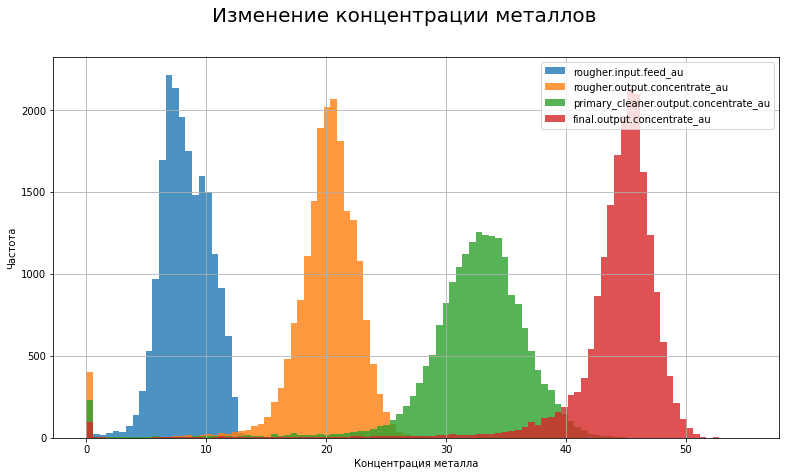

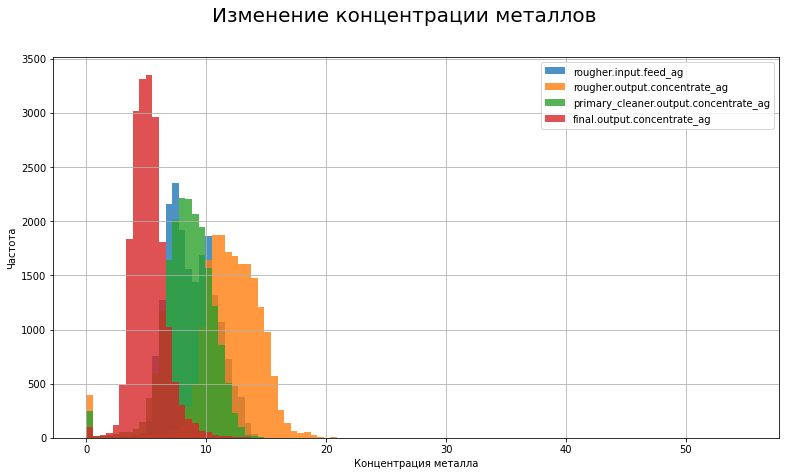

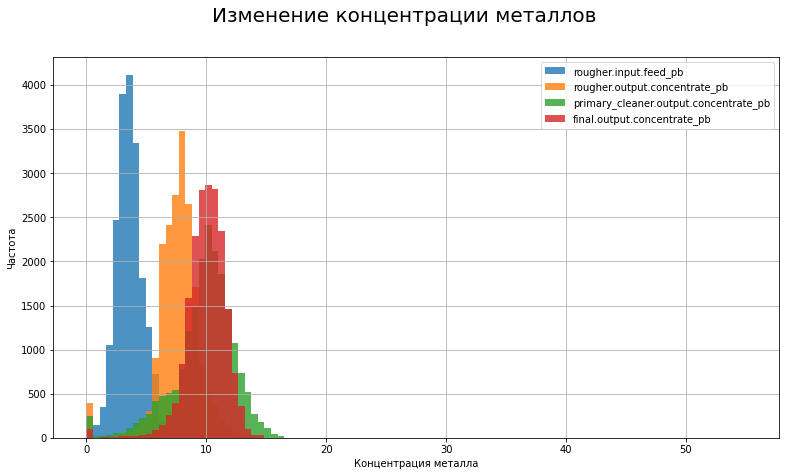

In [26]:
metal_list = [aurum, argentum, plumbum]
name = ["Au", "Ag", "Pb"]
for metal in metal_list:
    df_full[metal].plot(kind='hist', bins=100, grid=True, figsize=(13, 7), range=(0, 55), alpha=0.8)
    plt.suptitle(f'Изменение концентрации металлов', fontsize=20)
    plt.xlabel("Концентрация металла")
    plt.ylabel("Частота")
    plt.show()

In [27]:
df_full.shape

(19439, 86)

In [28]:
# на данном этапе удаляем выбивающиеся значения. За порог принято значение 1.5%, основываясь на диаграммах изменения концентрация металлов
df_full = df_full[df_full['rougher.output.concentrate_au'] >= 1.5]
df_full = df_full[df_full['primary_cleaner.output.concentrate_au'] >= 1.5]
df_full = df_full[df_full['final.output.concentrate_au'] >= 1.5]
df_full = df_full[df_full['rougher.output.concentrate_ag'] >= 1.5]
df_full = df_full[df_full['primary_cleaner.output.concentrate_ag'] >= 1.5]
df_full = df_full[df_full['final.output.concentrate_ag'] >= 1.5]
df_full = df_full[df_full['rougher.output.concentrate_pb'] >= 1.5]
df_full = df_full[df_full['primary_cleaner.output.concentrate_pb'] >= 1.5]
df_full = df_full[df_full['final.output.concentrate_pb'] >= 1.5]

In [29]:
df_full.shape

(18634, 86)

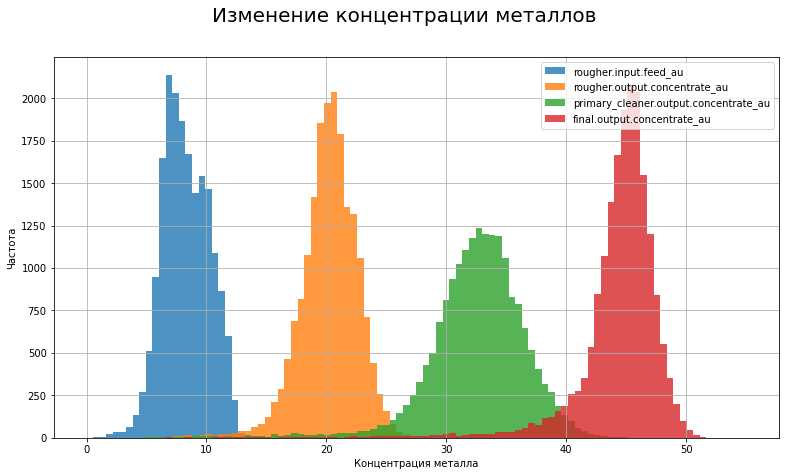

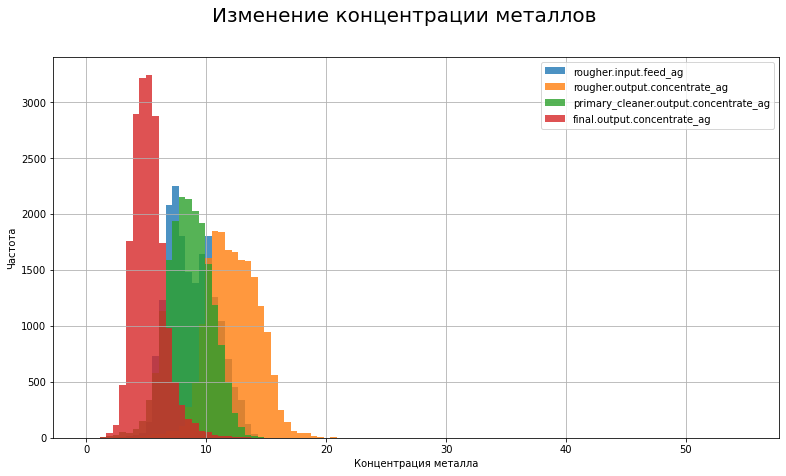

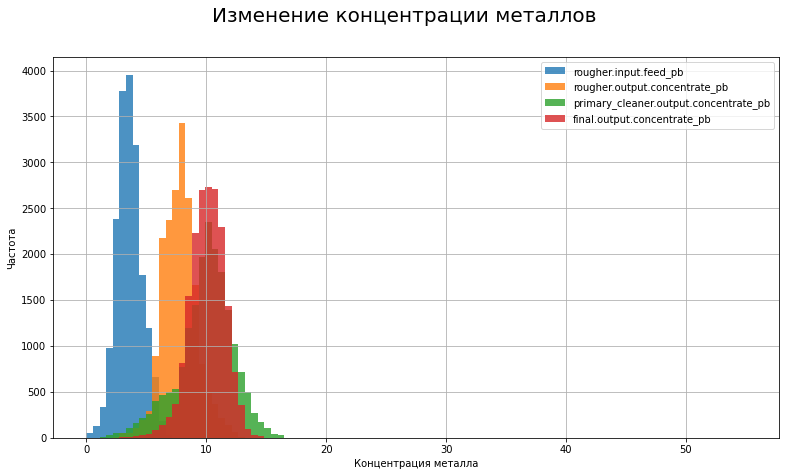

In [30]:
# проверка результатов обработки данных
metal_list = [aurum, argentum, plumbum]
name = ["Au", "Ag", "Pb"]
for metal in metal_list:
    df_full[metal].plot(kind='hist', bins=100, grid=True, figsize=(13, 7), range=(0, 55), alpha=0.8)
    plt.suptitle(f'Изменение концентрации металлов', fontsize=20)
    plt.xlabel("Концентрация металла")
    plt.ylabel("Частота")
    plt.show()

In [31]:
print("Длина обучающей выборки до удаления выбросов:", df_train.shape[0])
print("Длина тестовой выборки до удаления выбросов:", df_test.shape[0])

Длина обучающей выборки до удаления выбросов: 14579
Длина тестовой выборки до удаления выбросов: 4860


In [32]:
df_train = df_train[df_train.index.isin(df_full.index)]
df_test = df_test[df_test.index.isin(df_full.index)]

In [33]:
print("Длина обучающей выборки после удаления выбросов:", df_train.shape[0])
print("Длина тестовой выборки после удаления выбросов:", df_test.shape[0])

Длина обучающей выборки после удаления выбросов: 13810
Длина тестовой выборки после удаления выбросов: 4824


**Вывод:** Наиболее выраженное изменение концентрации наблюдается у золота, доля в среднем увеличилась с 8% до 45%. Концентрация серебра, напротив, уменьшилась, что говорит о том, что серебро ушло вместе с отвальными хвостами. Концентрация свинца увеличилась незначительно (с 4% до 10%). Также можно увидеть значения концентраций после очисток и флотации равное 0. Возможно, это связано с некорректными измерениями. Все аномалии удалены.

### Сравните распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

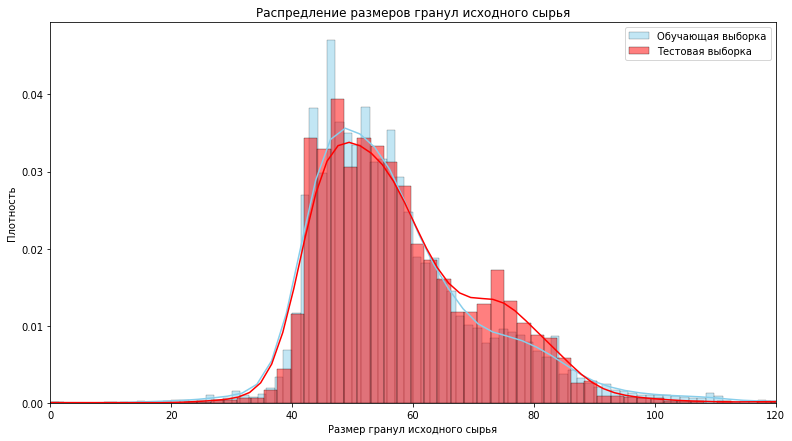

In [34]:
plt.figure(figsize=(13, 7))
sns.histplot(data=df_train, x="rougher.input.feed_size", color="skyblue", label="Обучающая выборка", kde=True, stat='density', common_norm=False)
sns.histplot(data=df_test, x="rougher.input.feed_size", color="red", label="Тестовая выборка", kde=True, stat='density', common_norm=False)

plt.xlim(0, 120)
plt.title('Распредление размеров гранул исходного сырья')
plt.xlabel('Размер гранул исходного сырья')
plt.ylabel('Плотность')
plt.legend() 
plt.show()

**Вывод:** Распредления размеров гранул исходного сырья в обучающей и тестовой выборках похожи, оценка будущих моделей должна быть правильной.

### Исследуйте суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [35]:
# помещаем названия целевых столбцов в соответствующие переменные
input = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
rougher_output = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
primary_cleaner = ['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol']
final_output = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

In [36]:
# суммируем значения целевых столбцов
total_input = df_full[input[0]] + df_full[input[1]] + df_full[input[2]] + df_full[input[3]]
total_rougher_output = df_full[rougher_output[0]] + df_full[rougher_output[1]] + df_full[rougher_output[2]] + df_full[rougher_output[3]]
total_primary_cleaner = df_full[primary_cleaner[0]] + df_full[primary_cleaner[1]] + df_full[primary_cleaner[2]] + df_full[primary_cleaner[3]]
total_final_output = df_full[final_output[0]] + df_full[final_output[1]] + df_full[final_output[2]] + df_full[final_output[3]]

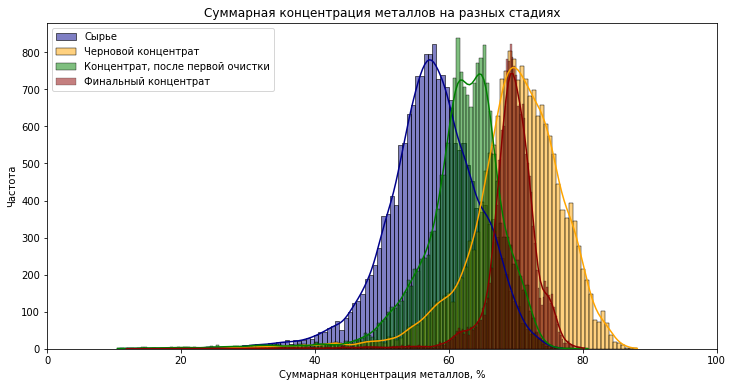

In [37]:
plt.figure(figsize=(12, 6))
sns.histplot(data=total_input, color="darkblue", label="Сырье", kde=True)
sns.histplot(data=total_rougher_output, color="orange", label="Черновой концентрат", kde=True)
sns.histplot(data=total_primary_cleaner, color="green", label="Концентрат, после первой очистки", kde=True)
sns.histplot(data=total_final_output, color="darkred", label="Финальный концентрат", kde=True)

plt.xlim(0, 100)
plt.title('Суммарная концентрация металлов на разных стадиях')
plt.xlabel('Суммарная концентрация металлов, %')
plt.ylabel('Частота')
plt.legend() 
plt.show()

Как видно из диаграммы, в ходе процесса обогащения золота наблюдается увеличение суммарной концентрации металлов. В исходном сырье минимальная концентрация металлов, после флотации происходит её резкое увеличение. После первой очистки концентрация снижается, поскольку удаляются ненужные металлы, а в финальном концентрации увеличивается доля золота.
<br> 

**Вывод:** Построена диграмма распределения суммарной концентрации в зависимости от стадии обработки золота. 

## Шаг 3. Построение моделей

### Напишите функцию для вычисления итоговой sMAPE.

In [38]:
def smape(target_rough,prediction_rough,target_final,prediction_final):

    # считаем smape для флотации
    
    smape_rough = abs(target_rough-prediction_rough)/((abs(target_rough)+abs(prediction_rough))/2)
    smape_rough = smape_rough.sum()*100/len(smape_rough)

    # считаем smape после очисток
    
    smape_final = abs(target_final-prediction_final)/((abs(target_final)+abs(prediction_final))/2)
    smape_final = smape_final.sum()*100/len(smape_final)
    
    return 0.25*smape_rough+0.75*smape_final

### Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [39]:
# перед созданием модели необходимо удалить столбец date
df_train.reset_index(inplace=True)
df_train.drop('date', axis=1, inplace=True)

In [40]:
features = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target = df_train[['rougher.output.recovery','final.output.recovery']]

#### Linear Regression

In [41]:
mae_rough = []
mae_final = []

smape_overall = []

sample_size = int(len(df_train)/3)

for i in range(0, len(df_train), sample_size):
    valid_indexes = df_train.iloc[i:i+sample_size].index 
    train_indexes = (df_train.iloc[:i] + df_train.iloc[i + sample_size:]).index
    
    features_train = features.iloc[train_indexes]
    features_valid = features.iloc[valid_indexes]
    target_train = target.iloc[train_indexes]
    target_valid = target.iloc[valid_indexes]

    model_LR = LinearRegression()

    # обучаем модель для пердсказания эффективности обогащения после флотации
    
    model_LR_rough = model_LR.fit(features_train, target_train['rougher.output.recovery'])
    predictions_LR_rough = model_LR_rough.predict(features_valid)
    predictions_LR_rough = pd.Series(predictions_LR_rough, index=features_valid.index)

    # обучаем модель для пердсказания финальной эффективности обогащения
    
    model_LR_final = model_LR.fit(features_train, target_train['final.output.recovery'])
    predictions_LR_final = model_LR_final.predict(features_valid)
    predictions_LR_final = pd.Series(predictions_LR_final,index=features_valid.index)
        
    smape_overall.append(smape(target_valid['rougher.output.recovery'], predictions_LR_rough, target_valid['final.output.recovery'], predictions_LR_final))


final_sMAPE_overall = np.array(smape_overall).mean()


print('Финальное sMAPE:', round(final_sMAPE_overall,3))

Финальное sMAPE: 8.928


**Использование автоматизированных средств проведения кросс-валидации**

In [42]:
def smape_for_cv(target,prediction):
    
    # считаем метрику для определенной стадии обогащения
    
    smape = abs(target-prediction)/((abs(target)+abs(prediction))/2)
    smape = smape.sum()*100/len(smape)
    return smape
    
def smape_overall_cv(smape_rougher, smape_final):

    #считаем финальную метрику
    
    return 0.25*smape_rougher+0.75*smape_final  

In [43]:
# создадим функцию оценки sMAPE на кросс-валидации
def cv_score(features, target, model):

    custom_score = make_scorer(smape_for_cv, greater_is_better=False)

    score = cross_val_score(model, features, target, cv=5, scoring=custom_score)
    
    return abs(score)

smape_rougher = cv_score(features, target[target.columns[0]], LinearRegression())
smape_final = cv_score(features, target[target.columns[1]], LinearRegression())
final_sMAPE_LR = smape_overall_cv(smape_rougher, smape_final)

print('Финальное sMAPE:', round(np.mean(final_sMAPE_LR), 3))

Финальное sMAPE: 8.948


#### Random Forest

In [44]:
results = defaultdict(list)    


for est in tqdm(range(2, 45, 10)):
    for max_depth in range(2,11):    
        model_RF_1 = RandomForestRegressor(random_state=12345, max_depth=max_depth, n_estimators=est)
        model_RF_2 = RandomForestRegressor(random_state=12345, max_depth=max_depth, n_estimators=est) 
    
        smape_rougher_1 = cv_score(features, target[target.columns[0]], model_RF_1)
        smape_final_1 = cv_score(features, target[target.columns[1]], model_RF_2)
    
        smape_overall_1 = smape_overall_cv(smape_rougher_1, smape_final_1)
        smape_overall_1 = np.mean(smape_overall_1)   
    
   
        results['smape_overall'].append(smape_overall_1)
        results['max_depth'].append(max_depth)
        results['n_estimators'].append(est)
        
pd.DataFrame(results).sort_values(by='smape_overall')

100%|██████████| 5/5 [29:16<00:00, 351.26s/it]


,smape_overall,max_depth,n_estimators
18,8.227397,2,22
9,8.228031,2,12
36,8.229568,2,42
27,8.246678,2,32
10,8.262804,3,12
0,8.282492,2,2
1,8.284707,3,2
19,8.290580,3,22
11,8.302237,4,12
21,8.324400,5,22


Наилучшее значение метрики sMAPE показала модель случайного леса, где были подобраны оптимальные гиперпараметры (max_depth=2, n_estimators=22). Проверим тестовую выборку на данной модели.

### Проверка на тестовой выборке

In [45]:
df_test.reset_index(inplace=True)
df_test.drop('date',axis=1,inplace=True)

features_test = df_test.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_test = df_test[['rougher.output.recovery','final.output.recovery']]

In [46]:
model_RF = RandomForestRegressor(random_state=12345, max_depth=2, n_estimators=22)

model_RF_rougher = model_RF.fit(features, target[target.columns[0]])
model_RF_final = model_RF.fit(features, target[target.columns[1]])

predictions_rougher = model_RF_rougher.predict(features_test)
predictions_final = model_RF_final.predict(features_test)

smape_rougher_test = smape_for_cv(target_test[target_test.columns[0]], predictions_rougher)
smape_final_test = smape_for_cv(target_test[target_test.columns[1]], predictions_final)                                     
                                         
final_sMAPE_test = smape_overall_cv(smape_rougher_test, smape_final_test)

print('Финальное sMAPE для тестовой выборки:', round(np.mean(final_sMAPE_test), 3))

Финальное sMAPE для тестовой выборки: 12.551


In [48]:
dummy_regressor = DummyRegressor(strategy='mean')

dummy_regressor_rougher = dummy_regressor.fit(features, target[target.columns[0]])
dummy_regressor_final = dummy_regressor.fit(features, target[target.columns[1]])

predictions_dummy_rougher_test = dummy_regressor_rougher.predict(features_test)
predictions_dummy_final_test = dummy_regressor_final.predict(features_test)

smape_dummy_rougher_test = smape_for_cv(target_test[target_test.columns[0]], predictions_dummy_rougher_test)
smape_dummy_final_test = smape_for_cv(target_test[target_test.columns[1]], predictions_dummy_final_test)

final_sMAPE_dummy = smape_overall_cv(smape_dummy_rougher_test, smape_dummy_final_test)

print('Финальное sMAPE для тестовой выборки с DummyRegressor:', round(np.mean(final_sMAPE_dummy), 3))

Финальное sMAPE для тестовой выборки с DummyRegressor: 12.946


Проверили модель на тестовой выборке, переобучения не наблюдается, показатель метрики не сильно расходится с обучающей выборкой. С помощью DummyRegressor проверили модель на адекватность, как итог, полученная модель показывает лучшую метрику, чем константная.  

## Общий вывод

В ходе работы на проектом выполнены следующие мероприятия:
- Загружены и проанализированы данные по процессу обогащения золота, проверена корректность расчета эффективности обогащения и проведена предобработка данных
- Детально рассмотрено изменение концентраций металлов на основных стадиях обогащения.
- Написана функция для расчета sMAPE (Symmetric Mean Absolute Percentage Error).
- Построены 2 модели, где подобраны оптимальные гиперпараметры для минимаизации sMAPE. Наилучшего значения на кросс-валидации удалось добиться для модели Случайный ЛЕС.
- При проверке качества модели на тестовой выборке метрика sMAPE оказалась на уровне обучающей выборки, явного переобучения не наблюдается. Сравнили полученную модель с константной, убедившись в её адеквантности. 